In [10]:
! which python

/Users/no_lineal/opt/anaconda3/envs/grid38/bin/python


In [11]:
import numpy as np

import scores

from scipy.ndimage import maximum_filter

from tqdm import tqdm

import os 

# viz
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [12]:
"""

    where am i?

"""

PATH = os.getcwd()
precomputed_path = PATH + '/precomputed/'

print( f'PATH: { PATH }' )
print( f'precomputed path: { precomputed_path }' )

PATH: /Users/no_lineal/Documents/GitHub/dm-grid-cells
precomputed path: /Users/no_lineal/Documents/GitHub/dm-grid-cells/precomputed/


In [13]:
""" 

    load dataset

"""

res_lst = sorted( [ x for x in os.listdir( precomputed_path + 'res/' ) if '.npy' in x] )
res_lst = [ 'res_999.npy' ]
res_lst = [ np.load( precomputed_path + 'res/' + x, allow_pickle=True, encoding='latin1' ) for x in res_lst ]

scores_lst = sorted( [ x for x in os.listdir( precomputed_path + 'scores/' ) if '.npy' in x ] )
scores_lst = [ 'scores_999.npy' ]
scores_lst = [ np.load( precomputed_path + 'scores/' + x, allow_pickle=True, encoding='latin1' ) for x in scores_lst ]

print( f'res_lst: { len(res_lst) }' )
print( f'scores_lst: { len(scores_lst) }' )

res_lst: 1
scores_lst: 1


In [14]:
"""  

    sample

"""

sample_idx = np.random.choice( len(res_lst) )

print('')
print( f'sample_idx: { sample_idx }' )
print('')

sample_scores = dict( scores_lst[ sample_idx ].item() )
sample_res = dict( res_lst[ sample_idx ].item() )

print( f'scores keys: { sample_scores.keys() }' )
print( f'res keys: { sample_res.keys() }' )
print('')


sample_idx: 0

scores keys: dict_keys(['btln_60_separation', 'lstm_90', 'btln_60', 'btln_90_separation', 'btln_90', 'lstm_60'])
res keys: dict_keys(['lstm', 'bottleneck', 'pos_xy'])



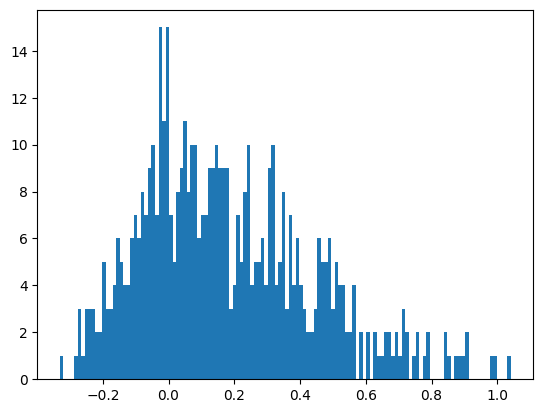

In [15]:
""" 

    score btln_60

"""

btln_60 = sample_scores[ 'btln_60' ]

plt.hist( btln_60, bins=int((btln_60.shape[0])/4) )
plt.show()

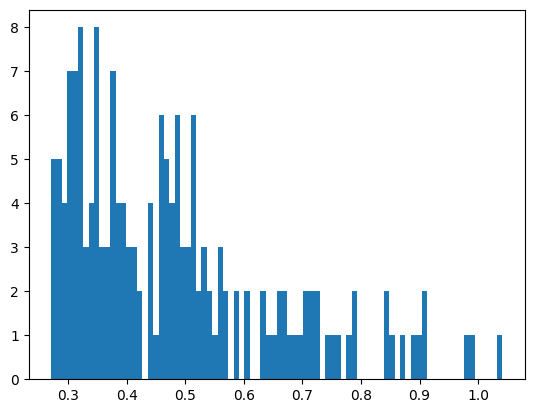

In [16]:
""" 

    filter by score

"""

btln_60_top_idx = np.where( btln_60 >= 0.27 )[0]

btln_60_top = btln_60[ btln_60_top_idx ]

plt.hist( btln_60_top, bins=int( btln_60_top.shape[0] / 2 ) )
plt.show()

sample_res_pos: (4000, 100, 2)
sample_res_btln: (4000, 100, 512)



100%|██████████| 512/512 [00:03<00:00, 152.70it/s]



xy: (400000, 2)
act: (400000, 512)
n_units: 512

s: 512
s_0: (20, 20)
score_60: 512
score_90: 512
max_60_mask: 512
max_90_mask: 512
sac: 512


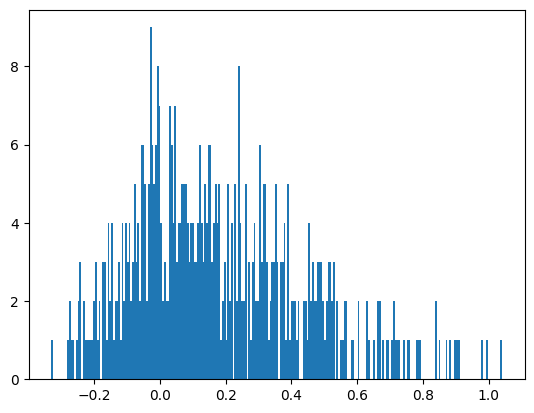

In [17]:
""" 

    get scores

"""

sample_res_pos = sample_res[ 'pos_xy' ]
sample_res_btln = sample_res[ 'bottleneck' ]

print( f'sample_res_pos: { sample_res_pos.shape }' )
print( f'sample_res_btln: { sample_res_btln.shape }' )
print('')

starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
masks_parameters = zip(starts, ends.tolist())

coord_range = ( (-1.1, 1.1), (-1.1, 1.1) )

res = 20
latest_epoch_scorer = scores.GridScorer( res, coord_range, masks_parameters )

# concatenate trajectories
xy = sample_res_pos.reshape(-1, sample_res_pos.shape[-1])
act = sample_res_btln.reshape(-1, sample_res_btln.shape[-1])
n_units = act.shape[1]

# get ratemap for each unit
s = [ latest_epoch_scorer.calculate_ratemap(xy[:, 0], xy[:, 1], act[:, i]) for i in tqdm(range(n_units)) ]

# Get the scores
score_60, score_90, max_60_mask, max_90_mask, sac = zip( * [ latest_epoch_scorer.get_scores(rate_map) for rate_map in tqdm(s) ] )

print('')
print( f'xy: { xy.shape }' )
print( f'act: { act.shape }' )
print( f'n_units: { n_units }' )
print('')
print( f's: { len(s) }' )
print( f's_0: {s[0].shape}' )
print( f'score_60: { len(score_60) }' )
print( f'score_90: { len(score_90) }' )
print( f'max_60_mask: { len(max_60_mask) }' )
print( f'max_90_mask: { len(max_90_mask) }' )
print( f'sac: { len(sac) }' )

plt.hist( score_60, bins=int( len(score_60) / 2 ) )
plt.show()

In [ ]:
np.save( precomputed_path + 's_20.npy', s )
np.save( precomputed_path + 'score_60_20.npy', score_60 )
np.save( precomputed_path + 'score_90_20.npy', score_90 )
np.save( precomputed_path + 'max_60_mask_20.npy', max_60_mask )
np.save( precomputed_path + 'max_90_mask_20.npy', max_90_mask )
np.save( precomputed_path + 'sac_20.npy', sac )

In [ ]:
""" 

    filter by score

"""

score_60 = np.array( score_60 )
score_60_top_idx = np.where( score_60 >= 0.25 )[0]
score_60_top = score_60[ score_60_top_idx ]

plt.hist( score_60_top, bins=int( score_60_top.shape[0] / 2 ) )
plt.show()

In [ ]:
""" 

    peak filter

"""

def peak_filter( sac ):

    global_max = []
    local_max = []
    distances = []

    for s in tqdm(sac):
        
        #global_max_pos = np.unravel_index( s.argmax(), s.shape )
        global_max_pos = (99, 99)
        local_max_pos = maximum_filter(s, footprint=np.ones( (50, 50) ), mode='wrap')

        dists = [ np.linalg.norm( np.array( global_max_pos ) - np.array( pos ) ) for pos in np.argwhere( local_max_pos == s ) ]

        global_max.append( global_max_pos )
        local_max.append( local_max_pos )
        distances.append( dists )

    return global_max, local_max, distances

sac = np.array( sac )
global_max, local_max, dists = peak_filter( sac )

print( f'sac: { sac.shape }' )
print( f'global_max: { len(global_max) }' )
print( f'local_max: { len(local_max) }' )
print( f'dists: { len(dists) }' )

In [ ]:
""" 

    sac sample

"""

idx_sample = score_60_top_idx[0]

sac_sample = sac[ idx_sample ]
global_sample = global_max[ idx_sample ]
local_sample = local_max[ idx_sample ]
local_sample = np.argwhere( local_sample == sac_sample )
dists_sample = dists[ idx_sample ]

print( f'idx_sample: { idx_sample }' )
print( f'dists sample: { dists_sample }' )

plt.imshow( sac_sample )
plt.plot( local_sample[:,1], local_sample[:,0], 'b*' )
plt.plot( global_sample[1], global_sample[0], 'r*' )

plt.show()

In [ ]:
"""  

    viz top k

"""

def sort_max_score( score ):

    idxs = np.flip( np.argsort( score ) )

    return idxs

k = 10

score_idx = sort_max_score( score_60 )
score_top_idx = list(score_idx[:k])
score_top_idx = np.random.choice( score_idx, size=k, replace=False )

sac_sample = sac[ score_top_idx ]
score_60_sample = score_60[ score_top_idx ]
global_sample = np.array(global_max)[ score_top_idx ]
local_sample = np.array(local_max)[ score_top_idx ]
local_sample = [ np.argwhere( local_sample[i] == sac_sample[i] ) for i in range(k) ]
dists_sample = [ dists[ idx ] for idx in score_top_idx ]

print( f'idx_top_k: { score_top_idx }' )

fig, axs = plt.subplots( 1 , k, figsize=( 20, 10 ) )

for i in range( k ):

    axs[ i ].imshow( sac_sample[ i ] )
    axs[ i ].plot( local_sample[ i ][:,1], local_sample[ i ][:,0], 'b*' )
    axs[ i ].plot( global_sample[ i ][1], global_sample[ i ][0], 'r*' )
    axs[ i ].set_title( f'{  score_top_idx[i], round( score_60_sample[i], 3 ), round(np.mean( np.sort(dists_sample[i] )[:7]), 3) }' )

plt.tight_layout()
plt.show()

In [ ]:
dist_mean_top = [ np.mean(np.sort(dists[ idx ])[1:2]) for idx in score_60_top_idx ]

plt.hist( dist_mean_top, bins=int( len(dist_mean_top) / 10 ) )
plt.show()

In [ ]:
dist_mean = [ np.mean( np.sort( d )[1:2] ) for d in dists ]

plt.hist( dist_mean, bins=int( len(dist_mean) / 10 ), density=True )    
plt.show()